# My mood in 2019 (According to Spotify)
## To get the data: 
## https://towardsdatascience.com/get-your-spotify-streaming-history-with-python-d5a208bbcbd3

In [20]:
from collections import namedtuple
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font='georgia')
sns.set_style("ticks")

In [21]:
df = pd.read_csv('/users/richardkacirek/Desktop/spoty-records-master/output/final.csv', index_col = 0)
df.shape

(38214, 24)

In [22]:
#tracks playing time
df['secPlayed'] = df['msPlayed'] / 1000
df = df[df.columns[:-1].insert(4, df.columns[-1])] #moving seconds column to proper place
df = df[df.secPlayed > 60] #removing songs that were played for less than 60 secs
df.shape

(20055, 25)

In [23]:
df.head()

,name,endTime,artistName,trackName,secPlayed,msPlayed,datetime,danceability,energy,key,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,Sweet Child O' Mine,2020-01-30 18:25,Guns N' Roses,Sweet Child O' Mine,114.747,114747,2020-01-30 18:25:00,0.446,0.952,6.0,...,0.112,0.624,125.303,audio_features,7snQQk1zcKl8gZ92AnueZW,spotify:track:7snQQk1zcKl8gZ92AnueZW,https://api.spotify.com/v1/tracks/7snQQk1zcKl8...,https://api.spotify.com/v1/audio-analysis/7snQ...,356067.0,4.0
1,Sweet Child O' Mine,2020-01-30 18:29,Sheryl Crow,Sweet Child O' Mine,202.570,202570,2020-01-30 18:29:00,0.446,0.952,6.0,...,0.112,0.624,125.303,audio_features,7snQQk1zcKl8gZ92AnueZW,spotify:track:7snQQk1zcKl8gZ92AnueZW,https://api.spotify.com/v1/tracks/7snQQk1zcKl8...,https://api.spotify.com/v1/audio-analysis/7snQ...,356067.0,4.0
2,Sweet Child O' Mine,2020-01-30 19:06,Guns N' Roses,Sweet Child O' Mine,71.625,71625,2020-01-30 19:06:00,0.446,0.952,6.0,...,0.112,0.624,125.303,audio_features,7snQQk1zcKl8gZ92AnueZW,spotify:track:7snQQk1zcKl8gZ92AnueZW,https://api.spotify.com/v1/tracks/7snQQk1zcKl8...,https://api.spotify.com/v1/audio-analysis/7snQ...,356067.0,4.0
3,Fetish (feat. Gucci Mane),2020-01-30 19:46,Selena Gomez,Fetish (feat. Gucci Mane),182.090,182090,2020-01-30 19:46:00,0.708,0.618,2.0,...,0.062,0.265,123.013,audio_features,4lnAN2S1fcI0SjxEbksZVr,spotify:track:4lnAN2S1fcI0SjxEbksZVr,https://api.spotify.com/v1/tracks/4lnAN2S1fcI0...,https://api.spotify.com/v1/audio-analysis/4lnA...,186113.0,4.0
5,Sweet Child O' Mine,2020-01-30 19:52,Guns N' Roses,Sweet Child O' Mine,356.066,356066,2020-01-30 19:52:00,0.446,0.952,6.0,...,0.112,0.624,125.303,audio_features,7snQQk1zcKl8gZ92AnueZW,spotify:track:7snQQk1zcKl8gZ92AnueZW,https://api.spotify.com/v1/tracks/7snQQk1zcKl8...,https://api.spotify.com/v1/audio-analysis/7snQ...,356067.0,4.0


In [24]:
#identifying the month
df['month'] = df.endTime.str.split('-').apply(lambda x: (x[0], x[1]))

In [25]:
#listing months and features
months = list(set(df.month.values))
months.sort()
features = ['danceability', 'energy', 'speechiness', 'instrumentalness', 'valence']

In [26]:
#standardizing features (we're interested not in their absolute value, but in how each changed over time)
for feature in features:
    df[f'{feature}_zscore'] = ( df[feature] - df[feature].mean() ) / df[feature].std()

In [27]:
#making sure we standardized correctly: mean is 0 and std is 1
df[[feature + '_zscore' for feature in features]].describe().loc['mean':'std'].T

,mean,std
danceability_zscore,-9.322428e-14,1.0
energy_zscore,1.170122e-13,1.0
speechiness_zscore,8.616394e-15,1.0
instrumentalness_zscore,4.289443e-15,1.0
valence_zscore,7.652107e-14,1.0


In [28]:
#features averages by month
Month = namedtuple('Month', features)
avg_features_months = []
for month in months:
    df_month = df[df['month'] == month]
    avg_features = df_month.describe().loc['mean'][[feature + '_zscore' for feature in features]]
    month = Month(*avg_features)
    avg_features_months.append(month)

In [29]:
#labelling months
month_labels = [f'{month[1]}/{month[0]}' for month in months]
month_labels_short = [m[:3]+m[-2:] for m in month_labels]

In [30]:
def features_sns(features):
    fig, ax = plt.subplots(figsize = (25,10))
    x = [x for x in range(13)]

    for feature in features:
        y = [getattr(month, feature) for month in avg_features_months]
        fig = sns.lineplot(x,y, label=feature, linewidth=6, alpha=.7, marker='o', markersize=15)
    
    ax.set_xticks([x for x in range(13)])
    ax.set_xticklabels(labels=month_labels_short, rotation=45, ha='right', size=30)

    for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(30) 

    leg = ax.legend(loc = 'upper left', bbox_to_anchor=(1,1.03), prop={'size': 30})

    # get the individual lines inside legend and set line width
    for line in leg.get_lines():
        line.set_linewidth(10)
    
    ax.set_title('28 Mood (According to Spotify)', size = 50, pad = 30, fontname = 'sans-serif')

    return ax

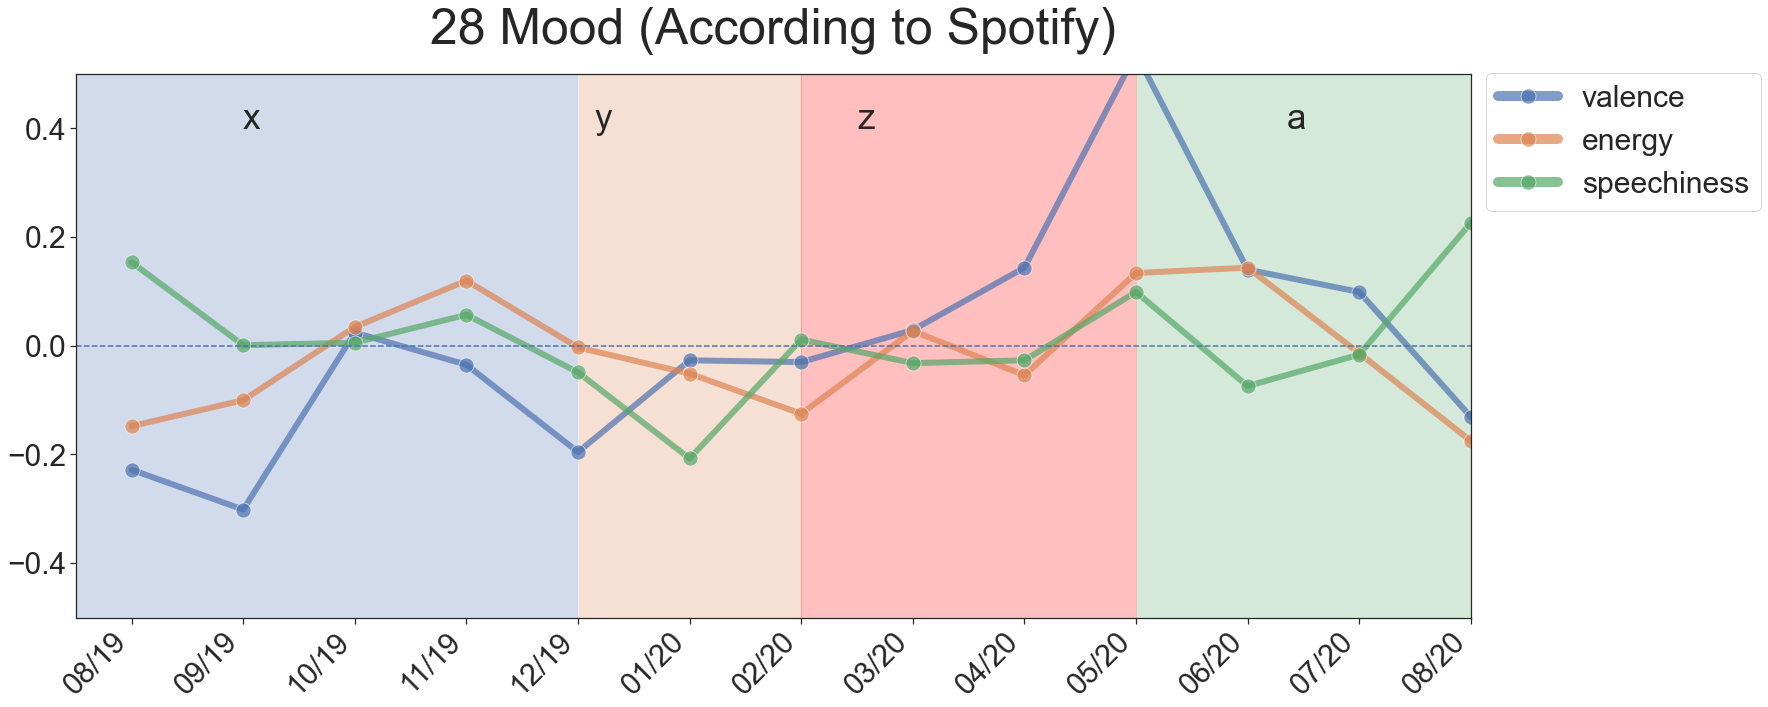

In [33]:
features_sns(['valence', 'energy', 'speechiness'])
x = [-1] + [x for x in range(13)]
alpha = .25
plt.ylim([-.5, .5])
plt.xlim([-.5, 12])

plt.fill_between(x[:6], -.5, 0.5, alpha=alpha)
plt.fill_between(x[5:8], -.5, 0.5, alpha=alpha)
plt.fill_between(x[7:11], -.5, 0.5, alpha=alpha, color="red")
plt.fill_between(x[10:], -.5, 0.5, alpha=alpha)

plt.annotate('x', (1, 0.4), size=35)
plt.annotate('y', (4.15, 0.4), size=35,)
plt.annotate('z', (6.5, 0.4), size=35,)
plt.annotate('a', (10.35, 0.4), size=35,)

plt.axhline(y=0, color='b', linestyle='--')


plt.show()